In [2]:
import pandas as pd 
import numpy as np 
import evoVAE.utils.metrics as mt 
import evoVAE.utils.seq_tools as st
from numba import njit, prange, jit
import random
#pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

In [2]:

def process_file_path(file_path):
    groups = [x for x in os.listdir(file_path) if x != ".DS_Store"]
    dirs = [file_path + x + "/" for x in os.listdir(file_path) if x != ".DS_Store"]

    return groups, dirs


def plot_clustering_loss(file_path, figure_name, rows, columns, max_reps: int = 10):

    groups, dirs = process_file_path(file_path)

    # Prepare the figure
    fig, axes = plt.subplots(rows, columns, figsize=(4, 2))  # 2 rows, 5 columns

    # Loop through groups and images
    # Two rows
    for col in range(columns):  # Five columns
        sampled = []
        for row in range(1, rows + 1):

            # to_show = random.randint(1, max_reps)
            # while to_show in sampled:
            #     to_show = random.randint(1, max_reps)
            
            # sampled.append(to_show)
            
            image_path = dirs[col] + f"{groups[col]}_r{row}/loss.png"
            
            # Load and display the image
            img = Image.open(image_path)
            axes[row - 1, col].imshow(img)
            axes[row - 1, col].axis('off')

    # Adjust layout
    # Reduce vertical space between subplots
    plt.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust vertical space between subplots (default is 0.2)
    plt.savefig(figure_name, dpi=800, bbox_inches='tight')
    plt.show()

def plot_standard_loss(file_path, figure_name, rows = 3, columns = 3, max_reps: int = 15):

    groups, dirs = process_file_path(file_path)

    # Prepare the figure
    fig, axes = plt.subplots(rows, columns, figsize=(4, 2)) 

    # Loop through groups and images
    # Two rows
    for col in range(columns):  # Five columns
        sampled = []
        for row in range(1, rows + 1):

            # to_show = random.randint(1, max_reps)
            # while to_show in sampled:
            #     to_show = random.randint(1, max_reps)
            
            #sampled.append(to_show)
            
            image_path = dirs[col] + f"{groups[col]}_r{row}/loss.png"
            
            # Load and display the image
            img = Image.open(image_path)
            axes[row - 1, col].imshow(img)
            axes[row - 1, col].axis('off')

    # Adjust layout
    # Reduce vertical space between subplots
    plt.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust vertical space between subplots (default is 0.2)
    plt.savefig(figure_name, dpi=800, bbox_inches='tight')
    plt.show()

def combine_standard_replicates(file_path, max_reps: int = 15):
    
    groups, dirs = process_file_path(file_path)

    df_list = []
    for r in range(1, max_reps + 1):
        for g, group in enumerate(groups):
            file = dirs[g] + f"{groups[g]}_r{r}/zero_shot_all_variants_final_metrics.csv"
            df_list.append(pd.read_csv(file))

    # #all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
    results = pd.concat(df_list, ignore_index=True)

    print(results.shape)
    return results

def combine_clustering_replicates(file_path, max_reps: int = 15):

    groups, dirs = process_file_path(file_path)

    df_list = []
    for r in range(1, max_reps + 1):
        for g, group in enumerate(groups):
            file = f"{file_path + groups[g]}/{groups[g]}_r{r}/zero_shot_all_variants_final_metrics.csv"
            df_list.append(pd.read_csv(file))

    # #all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
    cluster_results = pd.concat(df_list, ignore_index=True)
    print(cluster_results.shape)

    return cluster_results

def get_standard_label(lab):
        data = lab.split("/")[1].split("_")
        if len(data) == 3:
            # anc or extant
            return data[1]
        else:
            return "_".join(data[1:-1])
        

def plot_standard_metrics(std_results, protein_name):

    # use unique id to work out which sample it is 
    # get which replicate it is 
    get_rep = lambda x: int(x.split("/")[1].split("_")[-1][1:])
    # get extants, ancestor or anc_extant label in sample
   

    rep = std_results["unique_id"].apply(get_rep)

    ext_prop = std_results["unique_id"].apply(get_standard_label)

    std_results["replicate"] = rep
    std_results["sample"] = ext_prop

    labels = std_results["sample"].unique()
    labels.sort()
    
    points = [std_results.loc[std_results["sample"] == prop] for prop in labels]

    metrics = ["spearman_rho", "top_k_recall", "ndcg", "roc_auc", "pearson"]
    for m in metrics:

        
        means = [point[m].mean() for point in points]
        std_devs = [point[m].std() for point in points] 

        x_pos = np.arange(len(labels))

        fig, ax = plt.subplots()

        # Create bars
        bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)
        #ax.errorbar(x_pos, means, yerr=std_devs, fmt='o', capsize=5, color="black", elinewidth=2,)


        for i, point in enumerate(points):
            ax.scatter([i]*len(point), point[m], color='red', zorder=3, alpha=0.5)


        # Add labels
        ax.set_xlabel('Training data')
        ax.set_ylabel(f'Mean {m}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)

        #ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
        if m == "pearson":
            ax.set_title(f'{protein_name}: Average parwise covariance Pearson\'s correlation')
        else: 
            ax.set_title(f'{protein_name}: Average {m}')


        # Add a grid for better readability
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        plt.show()

    

def plot_clustering_metrics(cluster_results, protein_name):

    # get which replicate it is 
    get_rep = lambda x: int(x.split("/")[1].split("_")[-1][1:])
    # get proportion of extants in sample
    get_ex = lambda x: float(x.split("/")[1].split("_")[1]) 


    rep = cluster_results["unique_id"].apply(get_rep)

    ext_prop = cluster_results["unique_id"].apply(get_ex)

    cluster_results["replicate"] = rep
    cluster_results["sample"] = ext_prop

    labels = cluster_results["sample"].unique()
    labels.sort()
    
    points = [cluster_results.loc[cluster_results["sample"] == prop] for prop in labels]

    metrics = ["spearman_rho", "top_k_recall", "ndcg", "roc_auc", "pearson"]
    for m in metrics:

        
        means = [point[m].mean() for point in points]
        std_devs = [point[m].std() for point in points] 

        x_pos = np.arange(len(labels))

        fig, ax = plt.subplots()

        # Create bars
        #bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)
        ax.errorbar(x_pos, means, yerr=std_devs, fmt='-o', capsize=5, color="black", elinewidth=2,)


        for i, point in enumerate(points):
            ax.scatter([i]*len(point), point[m], color='red', zorder=3, alpha=0.5)


        # Add labels
        ax.set_xlabel('Extant sample proportion')
        ax.set_ylabel(f'Mean {m}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)

        #ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
        if m == "pearson":
            ax.set_title(f'{protein_name}: Average parwise covariance Pearson\'s correlation')
        else: 
            ax.set_title(f'{protein_name}: Average {m}')


        # Add a grid for better readability
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        plt.show()

def plot_metrics(df, labels, readable_labels, protein_name):

    points = [df.loc[df["sample"] == prop] for prop in labels]

    metrics = ["spearman_rho", "top_k_recall", "ndcg", "roc_auc", "pearson"]
    for m in metrics:

        means = [point[m].mean() for point in points]
        std_devs = [point[m].std() for point in points] 

        x_pos = np.arange(len(labels))

        fig, ax = plt.subplots()

        # Create bars
        bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)
        #ax.errorbar(x_pos, means, yerr=std_devs, fmt='o', capsize=5, color="black", elinewidth=2,)


        for i, point in enumerate(points):
            ax.scatter([i]*len(point), point[m], color='red', zorder=3, alpha=0.5)


        # Add labels
        ax.set_xlabel('Training data')
        ax.set_ylabel(f'Mean {m}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(readable_labels)

        #ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
        if m == "pearson":
            ax.set_title(f'{protein_name}: Pearson\'s correlation of actual vs reconstructed pairwise covariances')
        else: 
            ax.set_title(f'{protein_name}: Average {m}')


        # Add a grid for better readability
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        plt.show()



# GB1 clustering 

#### Creating replicates

1. Take output from mmSeqs which has clusters 
2. Separate into representative clusters 
3. Sample without replcement to make sample sizes of 10,000

In [ ]:
# this is the dataframe where all sampling will take place from, indices that are sampled will refer to this dataset
aln: pd.DataFrame = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/encoded_weighted/gb1_ancestors_extants_encoded_weighted_no_dupes.pkl")
aln = aln.drop_duplicates(subset=['sequence'])
#aln = aln.sample(frac=0.2)
print(aln.shape)
aln.head()

# get into numeric form for quicker processing 
msa, seq_key, key_label = st.convert_msa_numpy_array(aln)
msa.shape

In [ ]:

# read the mmSeqs clustering output 
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/mmseqs_clustering/gb1_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
# subsets of the dataframes based on the cluster it belongs too 
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape


In [ ]:
results.loc[results["is_ancestor"] == 0].shape

In [ ]:
# actual sampling and then write this to one csv per protein family 

SAMPLE_SIZE = 10000
extant_proportions = [0.15, 0.10, 0.05, 0.0]


aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/gb1_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        test[f"rep_{r}"] = indices

    test.to_csv(f"gb1_{p}_replicates.csv", index=False)
#st.write_fasta_file(f"./clusters/gb1_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta", sample_seqs)

#### GB1 clustering results - loss

In [27]:
gb1_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/gb1_seb_clusters/"
#gb1_file_path = "/Users/sebs_mac/reweighting/gb1/clustering/"
figure_name = "gb1_cluster_loss.png"

#plot_clustering_loss(gb1_file_path, figure_name, columns=4, rows=3)

#### GB1 clustering results - metrics: 14 replicates

In [30]:
gb1_all_cluster_results = combine_clustering_replicates(gb1_file_path, max_reps=14)
gb1_all_cluster_results.head()

(56, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./gb1_0.0_extants_r1/,0.036463,0.196706,0.106826,0.611126,0.849703
1,./gb1_0.1_extants_r1/,0.018042,0.179432,0.074598,0.591279,0.860188
2,./gb1_0.05_extants_r1/,0.020521,0.174612,0.120950,0.587903,0.838026
3,./gb1_0.15_extants_r1/,-0.014783,0.182043,0.078944,0.571031,0.847458
4,./gb1_0.0_extants_r2/,0.016212,0.169523,0.113829,0.592730,0.855009


In [ ]:
test = gb1_all_cluster_results[gb1_all_cluster_results["unique_id"].apply(lambda x: x.split("_")[1]) == "0.15"]
np.mean(test["spearman_rho"])

In [ ]:
np.mean(test["spearman_rho"])

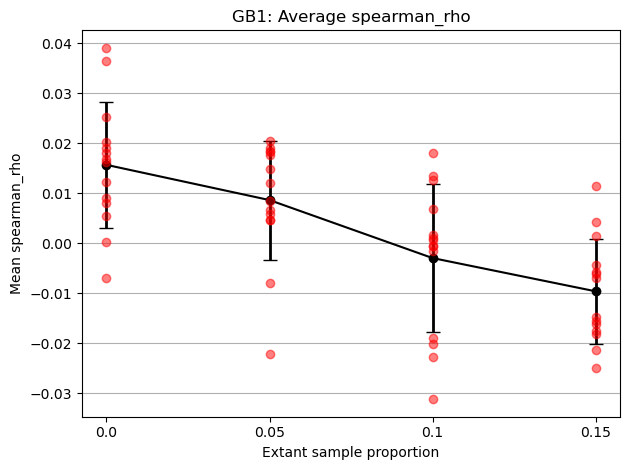

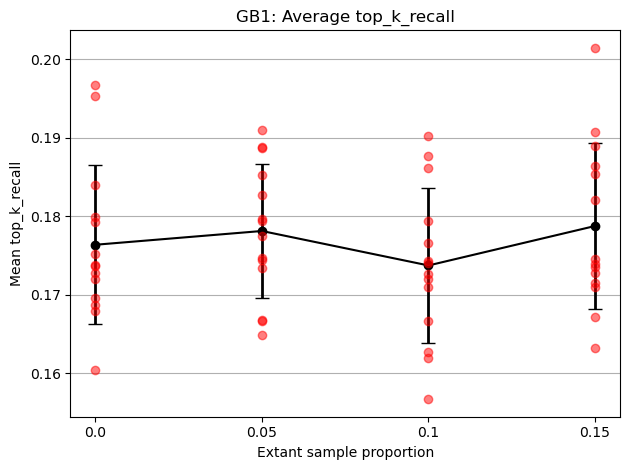

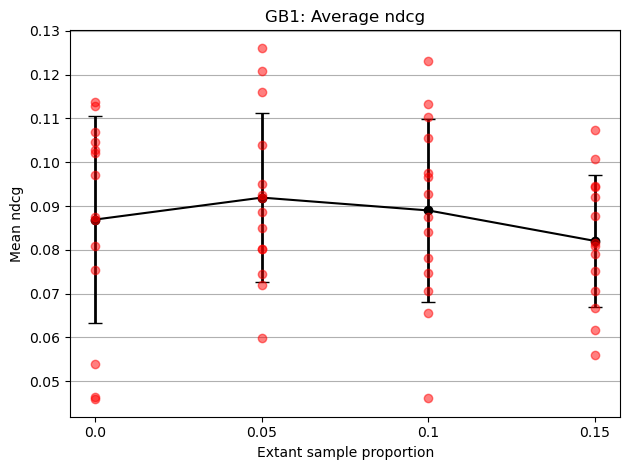

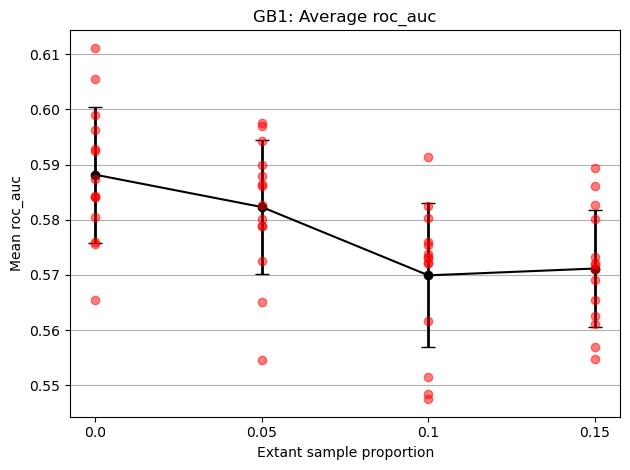

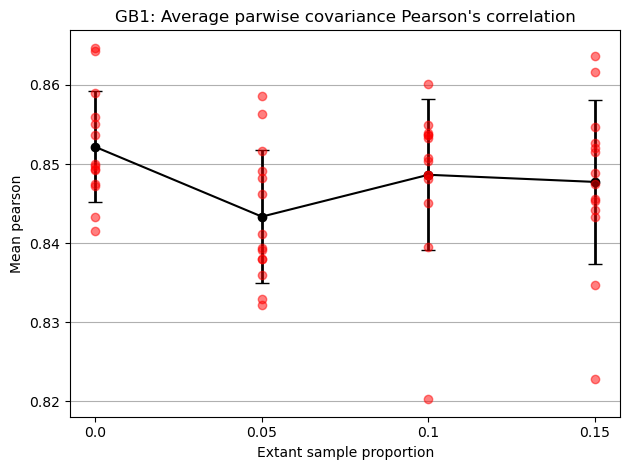

In [31]:
plot_clustering_metrics(gb1_all_cluster_results, "GB1")

#### GB1 Standard - loss

In [ ]:
gb1_std_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gb1_standard/"
#gb1_std_file_path = "/Users/sebs_mac/reweighting/gb1/standard/"
plot_standard_loss(gb1_std_file_path, "gb1_std_loss.png", columns=3, rows=3)

#### GB1 - standard results - metrics: 14 replicates

['ae' 'a' 'e' 'negative']


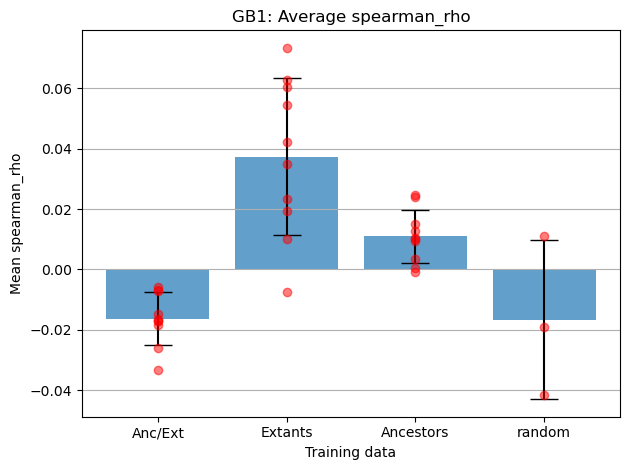

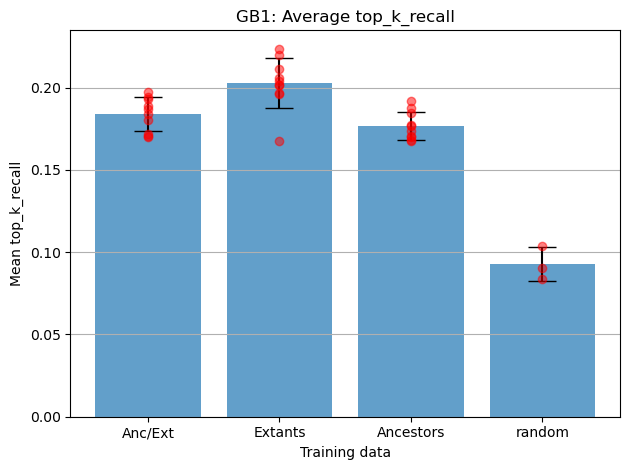

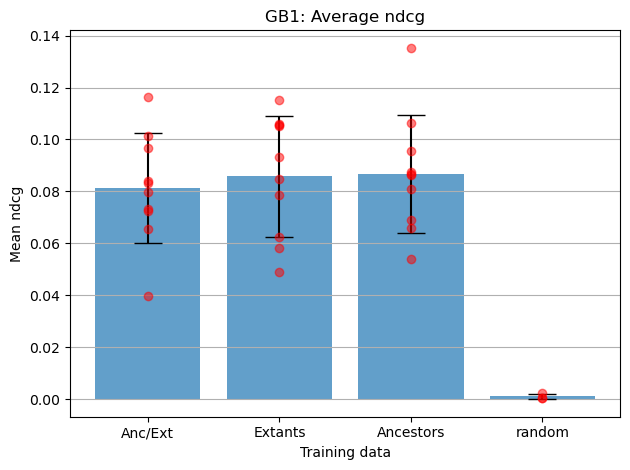

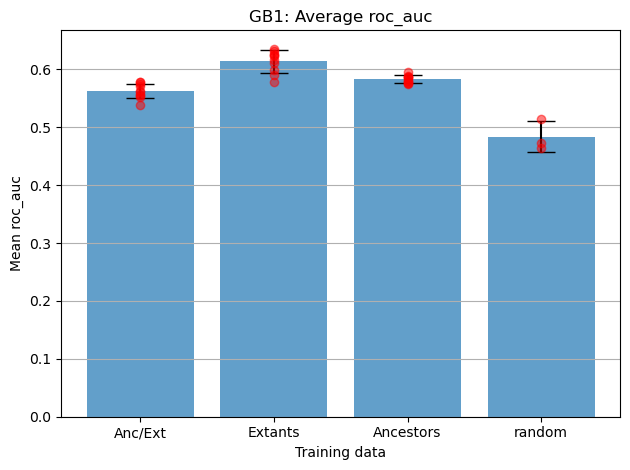

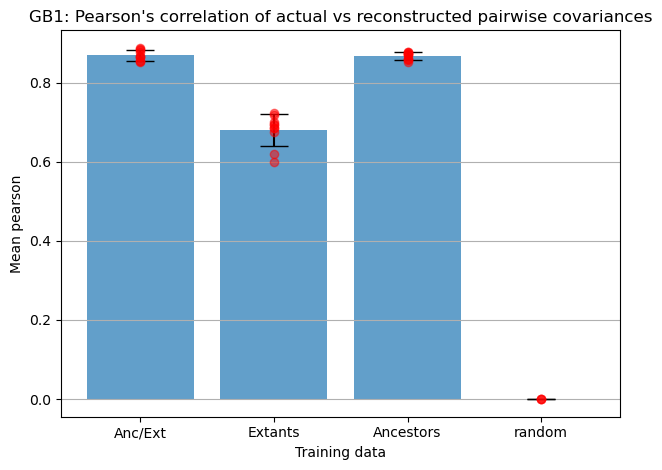

In [117]:
standard_gb1 = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gb1_compiled_results/gb1_standard_results.csv")

print(standard_gb1["sample"].unique())
protein_name = "GB1"

labels = ["ae", "e", "a", "negative"]
readable_labels = ["Anc/Ext", "Extants", "Ancestors", "random"]

plot_metrics(standard_gb1, labels, readable_labels, "GB1")

# GB1 - curated ancestor set

In [110]:
curated_gb1 = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gb1_compiled_results/gb1_curated_ancestors_results.csv")

print(curated_gb1["sample"].unique())
protein_name = "Curated GB1"

labels = ["0.32_a_0.32_e", "0.32_e", "0.32_a", "negative"]
readable_labels = ["Anc/Ext", "Extants", "Ancestors", "random"]

['0.32_a_0.32_e' '0.32_e' '0.32_a_e' '0.32_a' 'e' 'negative']


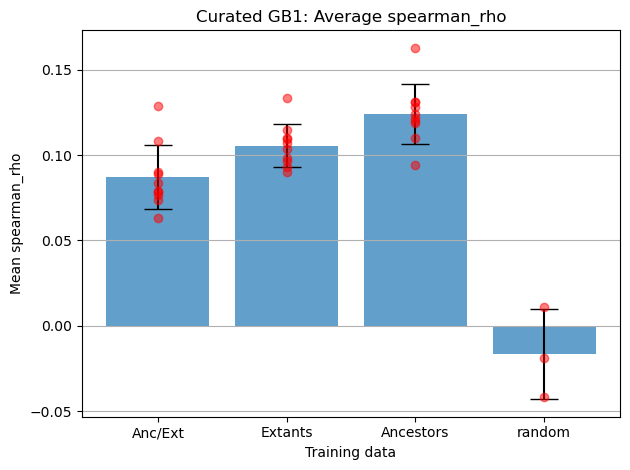

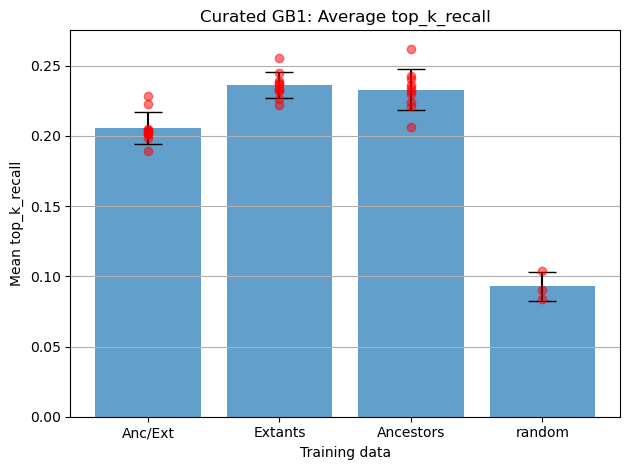

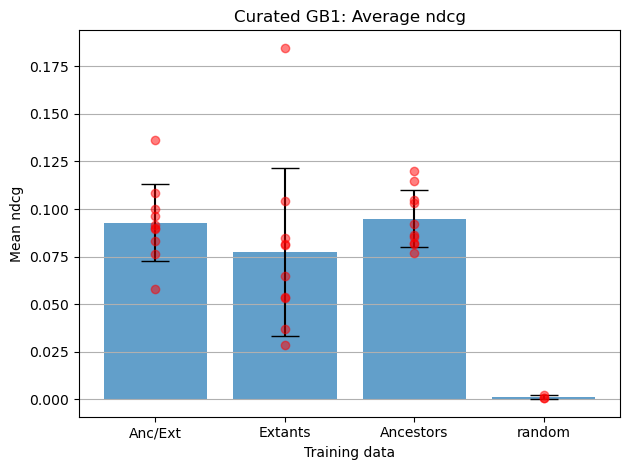

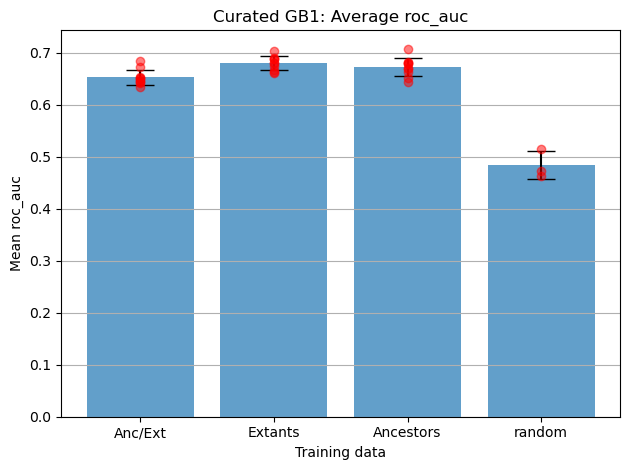

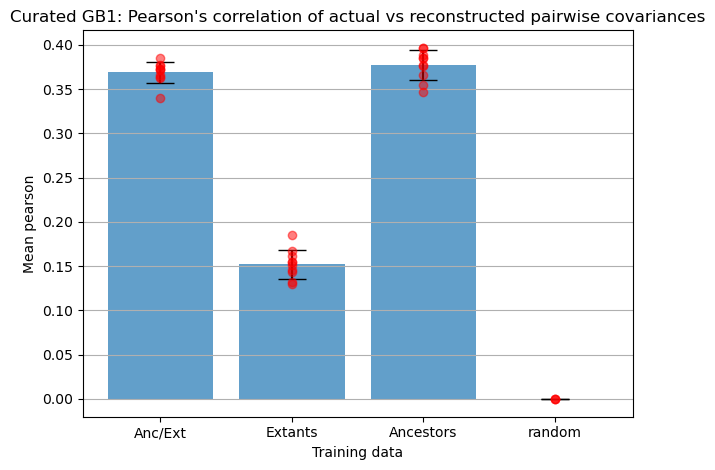

In [111]:
plot_metrics(curated_gb1, labels, readable_labels, "Curated GB1")


# A4 human clustering 

#### Getting cluster replicates

In [ ]:
# this is the dataframe where all sampling will take place from, indices that are sampled will refer to this dataset
a4_aln: pd.DataFrame = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/a4/encoded_weighted/a4_ancestors_extants_encoded_weighted_no_dupes.pkl")
#aln = aln.sample(frac=0.2)
print(a4_aln.shape)
a4_aln.head()

# get into numeric form for quicker processing 
a4_msa, seq_key, key_label = st.convert_msa_numpy_array(a4_aln)
a4_msa.shape


In [ ]:
# read the mmSeqs clustering output 
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/a4/mmseqs_clustering/a4_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
# subsets of the dataframes based on the cluster it belongs too 
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape

In [ ]:

SAMPLE_SIZE = 10000
extant_proportions = [0.0, 0.05, 0.1, 0.15, 0.2]


aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/a4/alns/a4_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        test[f"rep_{r}"] = indices

    test.to_csv(f"a4_{p}_replicates.csv", index=False)
#st.write_fasta_file(f"./clusters/gb1_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta", sample_seqs)

#### A4 clustering results - loss

In [21]:
a4_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/a4_seb_clusters/"
#a4_file_path = "/Users/sebs_mac/reweighting/a4/clustering/"
figure_name = "a4_cluster_loss.png"

plot_clustering_loss(a4_file_path, figure_name, rows=3, columns=5)

#### A4 clustering results - metrics: 15 replicates

In [ ]:
a4_all_cluster_results = combine_clustering_replicates(a4_file_path, max_reps=15)
a4_all_cluster_results.head()

In [ ]:
plot_clustering_metrics(a4_all_cluster_results, "A4")

#### A4 Standard results - loss

['e' 'ae' 'a' 'random']


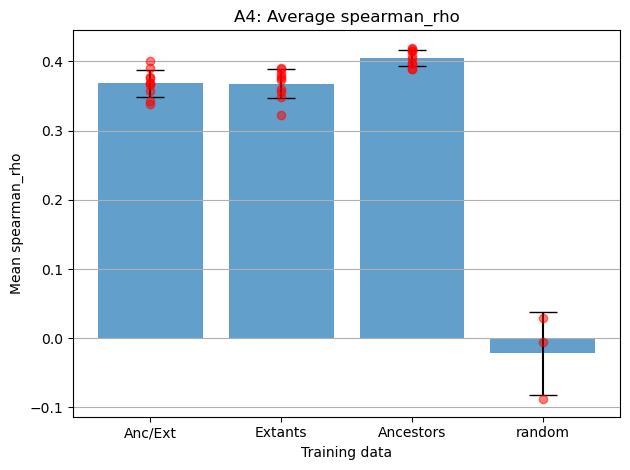

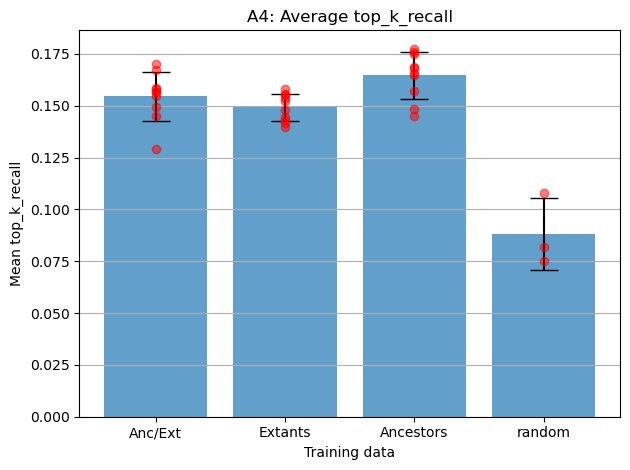

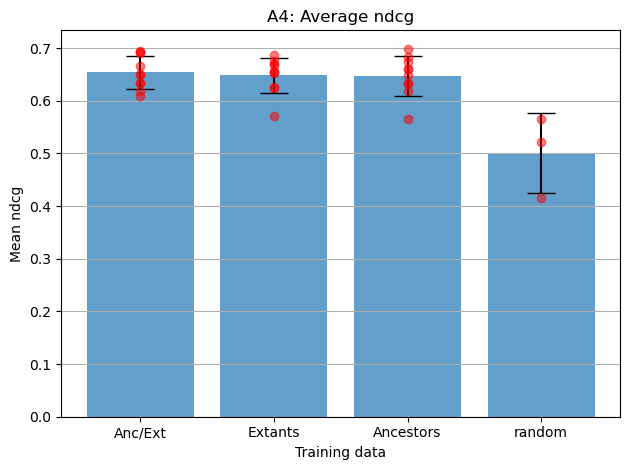

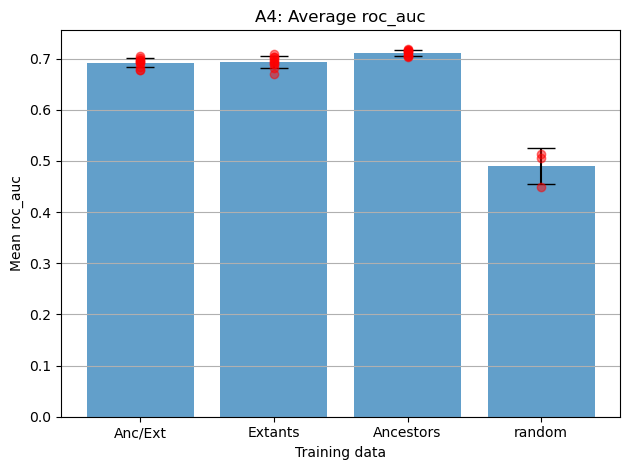

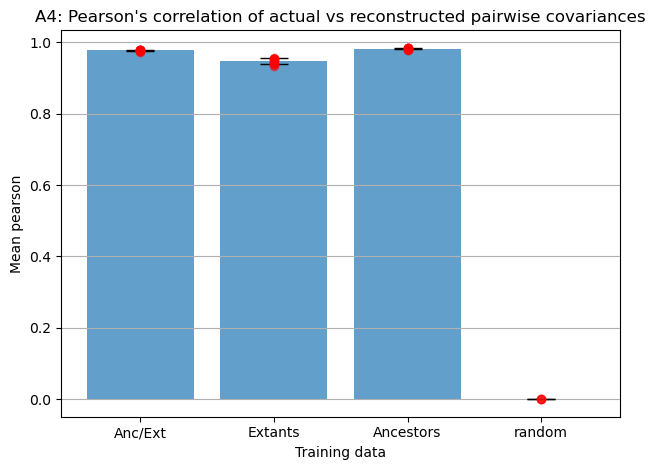

In [36]:

#plot_standard_loss(a4_std_file_path, "a4_std_loss.png", columns=3, rows=3)

path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/a4_compiled_results/"
a4 = pd.read_csv(path + "a4_standard_results.csv")

print(a4["sample"].unique())
protein_name = "A4"

labels = ["ae", "e", "a", "random"]
readable_labels = ["Anc/Ext", "Extants", "Ancestors", "random"]

plot_metrics(a4, labels, readable_labels, protein_name)

#### Curated A4

['a4_0.6_e' 'a4_0.6_a_0.6_e' 'a4_0.6_a' 'random ' 'random']


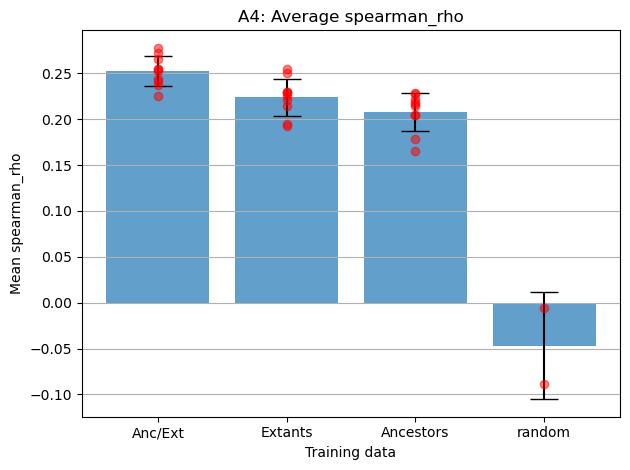

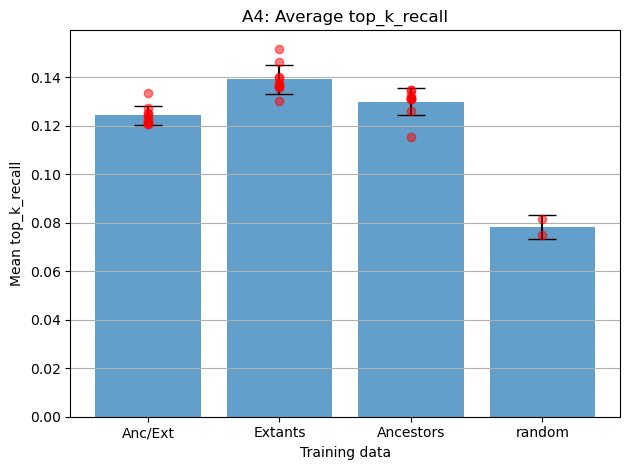

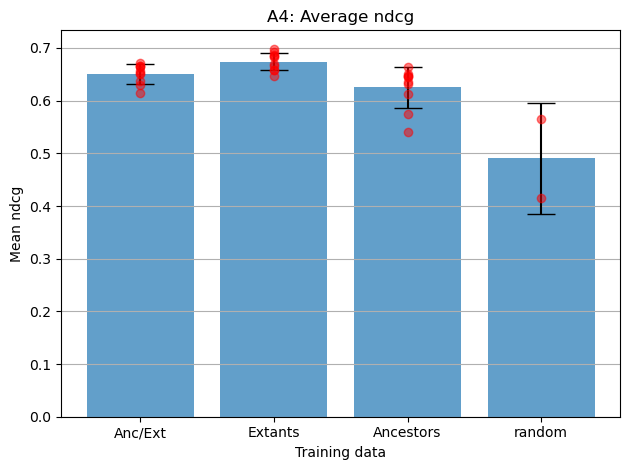

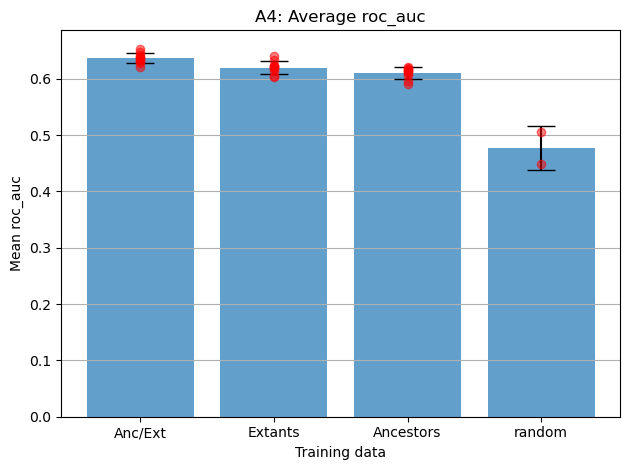

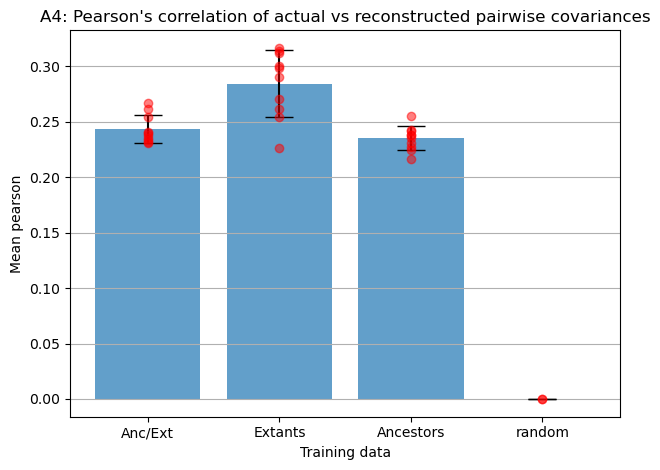

In [39]:

path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/a4_compiled_results/"
a4 = pd.read_csv(path + "a4_curated_results.csv")

print(a4["sample"].unique())
protein_name = "A4"

labels = ["a4_0.6_a_0.6_e", "a4_0.6_e", "a4_0.6_a", "random"]
readable_labels = ["Anc/Ext", "Extants", "Ancestors", "random"]

plot_metrics(a4, labels, readable_labels, protein_name)

# GCN4 clustering

#### GCN4 - getting cluster replicates

In [ ]:
clustering_results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/mmseqs_clustering/gcn4_an_ex_cluster.tsv", sep="\t", header=None)
clustering_results.columns = ["cluster", "sequence"]

mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = clustering_results["sequence"].apply(mark_ancestors)
clustering_results["is_ancestor"] = is_ancestor

representative_ids = clustering_results["cluster"].unique()

clustering_results
# divide the sequences into their clusters
clusters = [clustering_results.loc[clustering_results["cluster"] == rep] for rep in representative_ids]
len(clusters)

In [ ]:
import random
import evoVAE.utils.seq_tools as st


SAMPLE_SIZE = 5000
extant_proportions = [0.06, 0.04, 0.02, 0.0]


aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        test[f"rep_{r}"] = indices


    test.to_csv(f"gcn4_{p}_replicates.csv", index=False)
       


In [ ]:
import os
import pandas as pd

DATA_PATH = "/Users/sebs_mac/uni_OneDrive/honours/data/clustering_data/gcn4/"

#df_list = [pd.read_csv(file + "/_zero_shot.csv") for file in os.listdir(DATA_PATH)]
df_list = [pd.read_csv((DATA_PATH + str(file) + "/_zero_shot.csv")) for file in os.listdir(DATA_PATH) if str(file) != ".DS_Store"]

all_data = pd.read_csv("gcn4_cluster_sampling_results.csv")
all_data.drop(columns=["Unnamed: 0"], inplace=True)

get_rep = lambda x: x.split("_")[1] 
get_ex = lambda x: x.split("_")[11] 

rep = all_data["unique_id"].apply(get_rep)
ext_prop = all_data["unique_id"].apply(get_ex)
all_data["replicate"] = rep
all_data["extant_prop"] = ext_prop

a4_extant_proportions = all_data["extant_prop"].unique()
a4_extant_proportions.sort()

subsets = [all_data.loc[all_data["extant_prop"] == prop] for prop in a4_extant_proportions]



#### GCN4 clustering results - loss

In [ ]:
gcn4_file_path =  "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/gcn4_seb_clusters/"
#gcn4_file_path = "/Users/sebs_mac/reweighting/gcn4/clustering/"
#figure_name = "gcn4_cluster_loss.png"

#plot_clustering_loss(gcn4_file_path, figure_name, rows=3, columns=4)

#### GCN4 clustering results - metrics: 15 replicates

In [ ]:
gcn4_all_cluster_results = combine_clustering_replicates(gcn4_file_path, max_reps=15)
gcn4_all_cluster_results.head()

In [ ]:
plot_clustering_metrics(gcn4_all_cluster_results, "GCN4")

#### GCN4 Standard results - loss

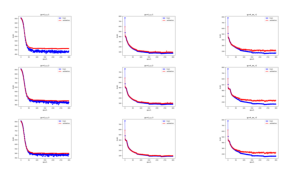

In [121]:
gcn4_std_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/raw_data/gcn4_standard/"
#gcn4_std_file_path = "/Users/sebs_mac/reweighting/gcn4/standard/"
plot_standard_loss(gcn4_std_file_path, "gcn4_std_loss.png", columns=3, rows=3)

#### GCN4 Standard results - metrics: 15 replicates

['e' 'a' 'ae' 'random']


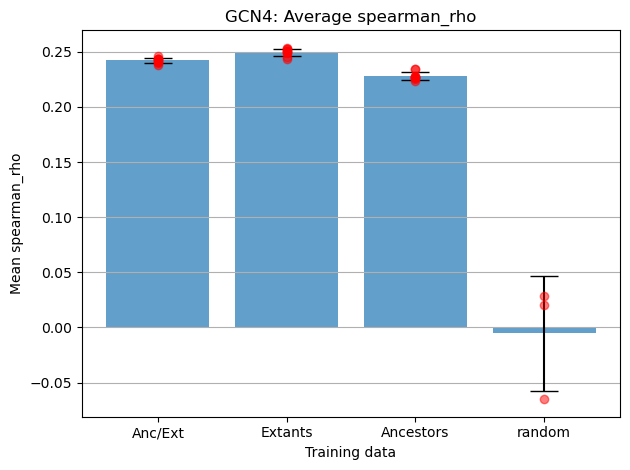

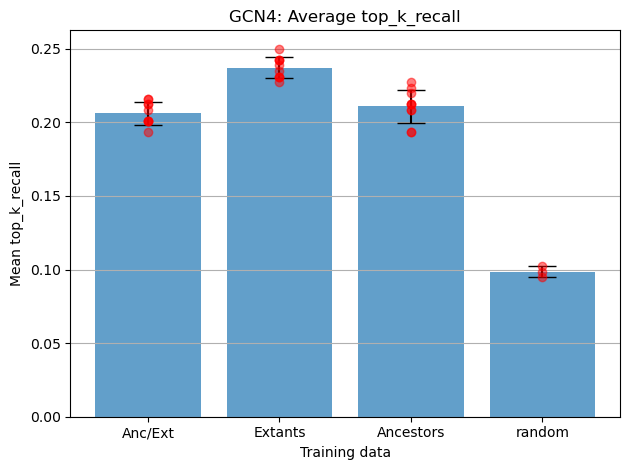

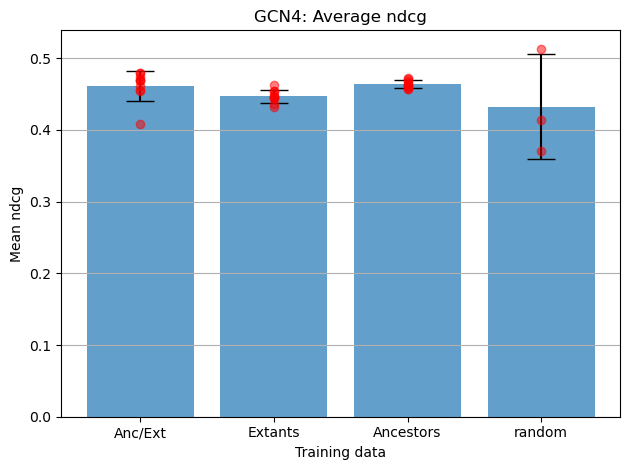

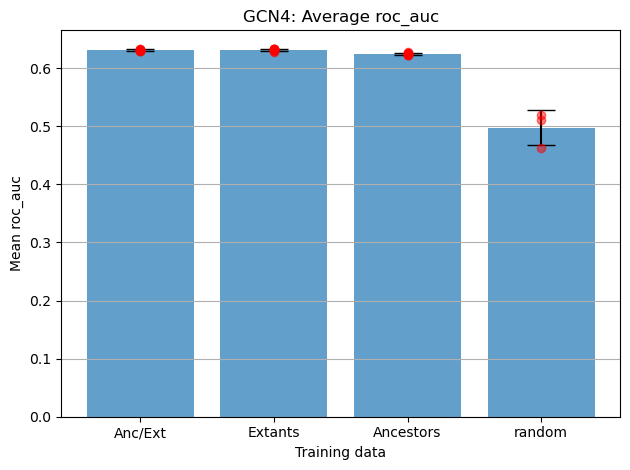

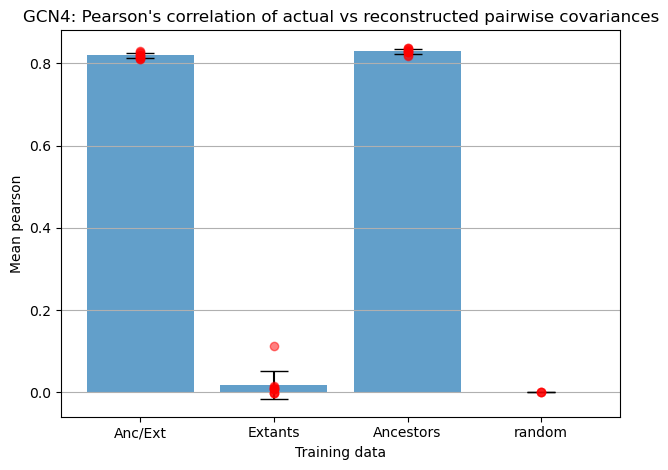

In [6]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gcn4_compiled_results/"
gcn4 = pd.read_csv(path + "gcn4_standard_results.csv")

print(gcn4["sample"].unique())
protein_name = "GCN4"

labels = ["ae", "e", "a", "random"]
readable_labels = ["Anc/Ext", "Extants", "Ancestors", "random"]

plot_metrics(gcn4, labels, readable_labels, protein_name)

## GCN4 Curated 

In [7]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gcn4_compiled_results/"
gcn4_curated = pd.read_csv(path + "gcn4_curated_ancestors_results.csv")

print(gcn4_curated["sample"].unique())
protein_name = "Curated GCN4"

labels = ["0.3_a_0.3_e", "0.3_e", "0.3_a", "random"]
readable_labels = ["Anc/Ext", "Extants", "Ancestors", "random"]

['0.3_e' '0.3_a' '0.3_a_0.3_e' 'random']


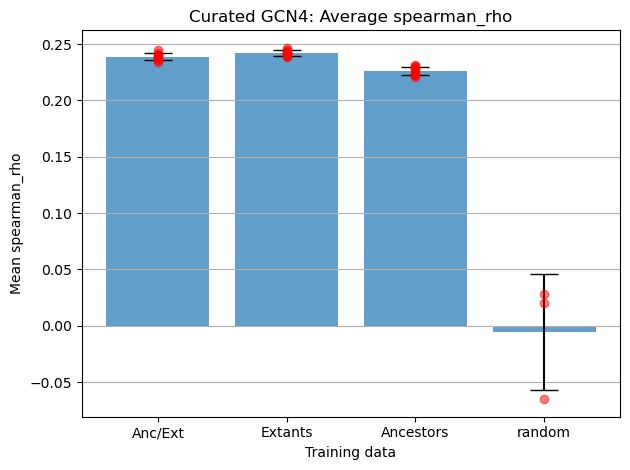

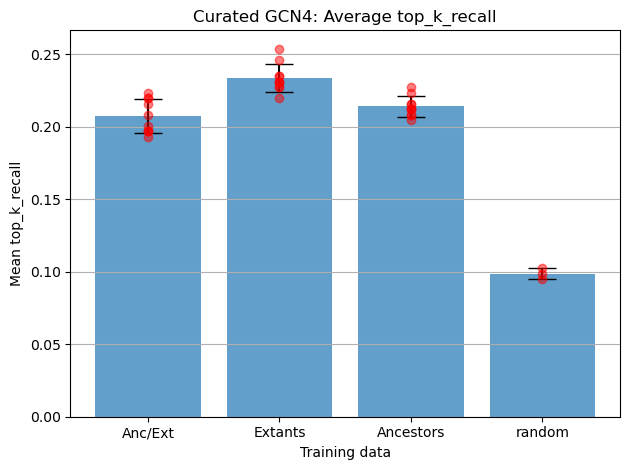

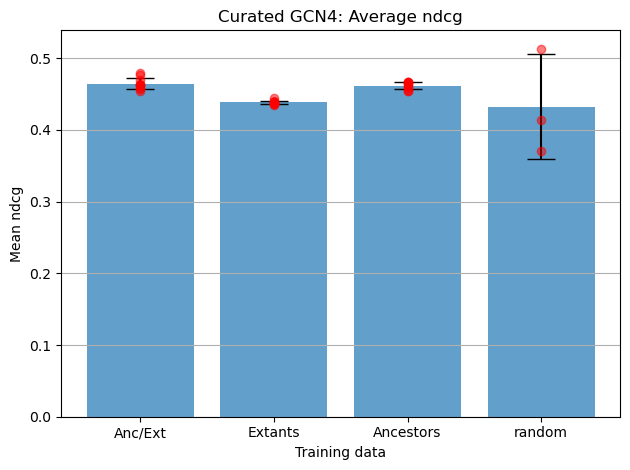

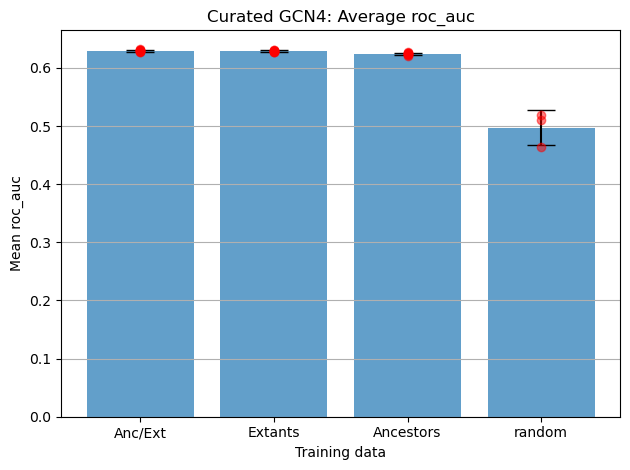

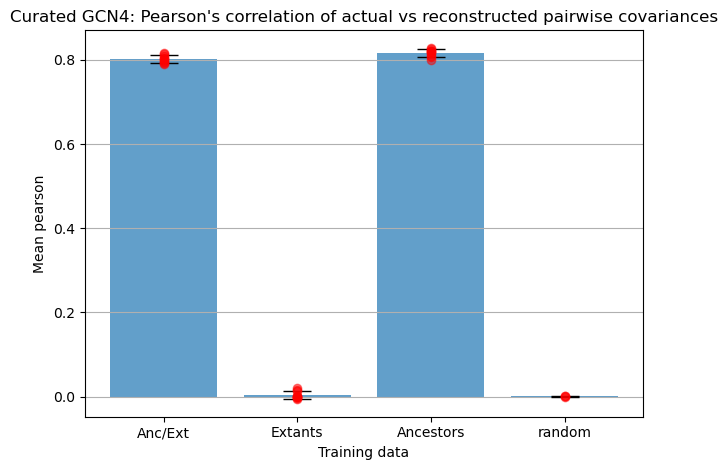

In [8]:
plot_metrics(gcn4_curated, labels, readable_labels, protein_name)

# GFP

#### Clustering

In [ ]:
aln: pd.DataFrame = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/alns/gfp_ancestors_extants_no_syn_no_dupes.pkl")

In [ ]:
aln.head()
st.write_fasta_file("/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/alns/gfp_ancestors_extants_no_syn_no_dupes.fasta", aln)

In [ ]:
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/mmseqs_clustering/gfp_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
# subsets of the dataframes based on the cluster it belongs too 
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape

In [ ]:
ancs = results[results["is_ancestor"] == 1]
extants = results[results["is_ancestor"] == 0]
ancs.shape, extants.shape

In [ ]:
aln[aln["id"] == "N288_tree_12"]

In [ ]:
SAMPLE_SIZE = 349
extant_proportions = [0.0, 0.05, 0.1, 0.15, 0.2]

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)

        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)

        test[f"rep_{r}"] = indices

    test.to_csv(f"gfp_{p}_replicates.csv", index=False)

In [ ]:
test = pd.read_csv("gfp_0.15_replicates.csv")["rep_11"]
thing = aln.loc[test]

In [ ]:
thing[thing["id"].str.contains("tree")]

##### GFP - standard

In [33]:
np.mean(gfp[gfp["sample"] == "ae"]["roc_auc"]), np.mean(gfp[gfp["sample"] == "e"]["roc_auc"]),  np.mean(gfp[gfp["sample"] == "a"]["roc_auc"])

(0.6309585052199699, 0.6316352073646897, 0.6245101482330045)

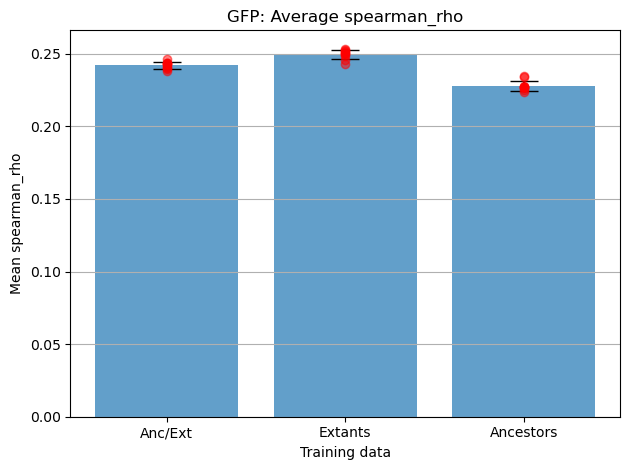

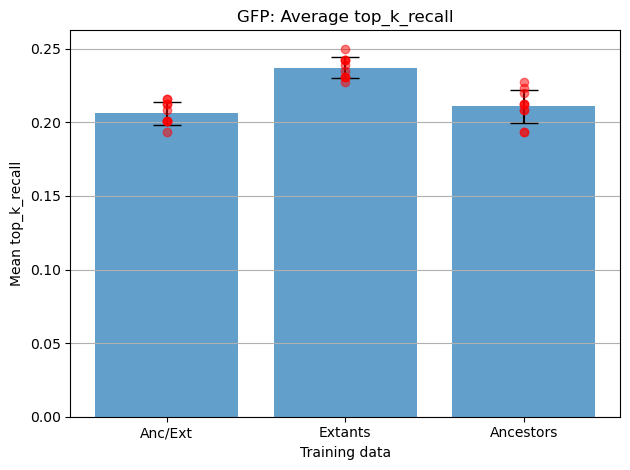

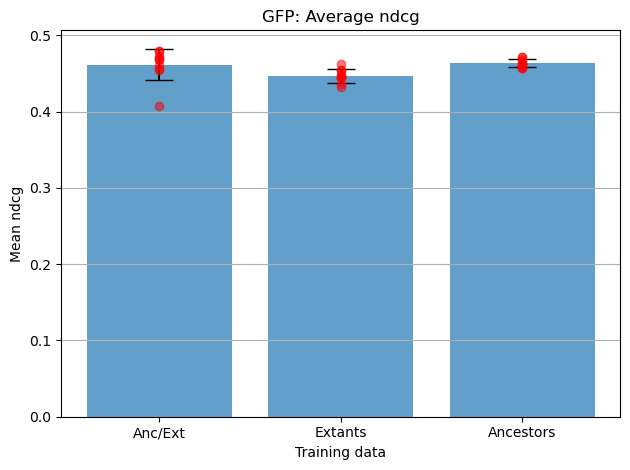

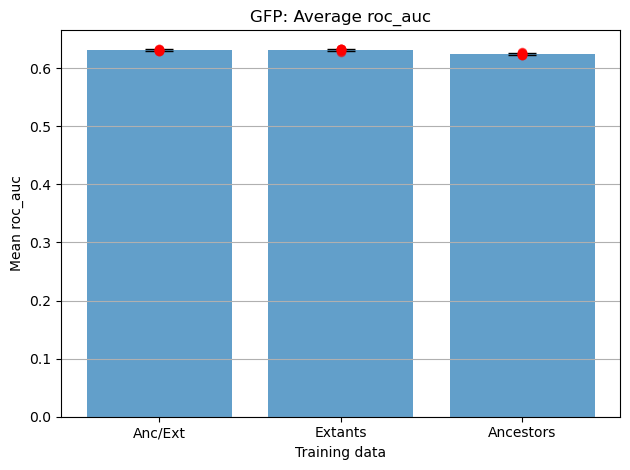

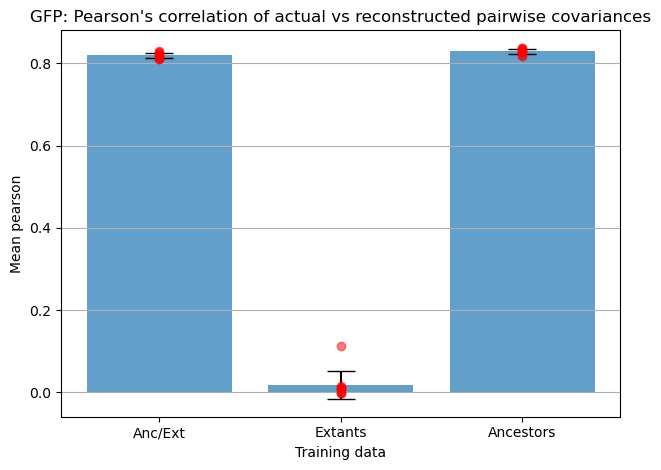

In [12]:

#plot_standard_loss(gfp_std_file_path, "gfp_std_loss.png", columns=3, rows=3)
gfp = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gfp_standard_results.csv")
protein_name = "GFP"
labels = ["ae", "e", "a"]
readable_labels = ["Anc/Ext", "Extants", "Ancestors"]

plot_metrics(gfp, labels, readable_labels, protein_name)

In [32]:
gfp

,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson,replicate,sample
0,./gcn4_e_r1/,0.253516,0.231061,0.431857,0.632543,0.014514,1,e
1,./gcn4_a_r1/,0.234026,0.208333,0.463126,0.627064,0.836800,1,a
2,./gcn4_ae_r1/,0.240747,0.193182,0.478914,0.630876,0.811255,1,ae
3,./gcn4_e_r2/,0.250479,0.231061,0.454369,0.632319,0.111296,2,e
4,./gcn4_a_r2/,0.227295,0.208333,0.472036,0.623613,0.828438,2,a
5,./gcn4_ae_r2/,0.243435,0.215909,0.455398,0.630731,0.813360,2,ae
6,./gcn4_e_r3/,0.248547,0.242424,0.454634,0.630800,0.007783,3,e
7,./gcn4_a_r3/,0.227357,0.212121,0.471014,0.624752,0.816834,3,a
8,./gcn4_ae_r3/,0.243731,0.200758,0.479551,0.632640,0.818293,3,ae
9,./gcn4_e_r4/,0.245537,0.250000,0.446276,0.629942,0.006728,4,e


#### GFP - clustering

In [19]:
gfp_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/gfp_seb_clusters/"
figure_name = "gfp_cluster_loss.png"
#plot_clustering_loss(gfp_file_path, figure_name, columns=5, rows=3)

In [20]:
gfp_all_cluster_results = combine_clustering_replicates(gfp_file_path, max_reps=15)
gfp_all_cluster_results.head()

(75, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./gfp_0.2_extants_r1/,0.632926,0.267208,0.867823,0.878339,0.076191
1,./gfp_0.15_extants_r1/,0.625356,0.262374,0.867232,0.873286,-0.009779
2,./gfp_0.1_extants_r1/,0.630765,0.265468,0.865650,0.876684,-0.007838
3,./gfp_0.0_extants_r1/,0.628664,0.267981,0.871733,0.874783,-0.012641
4,./gfp_0.05_extants_r1/,0.626134,0.262761,0.865603,0.874325,-0.012641


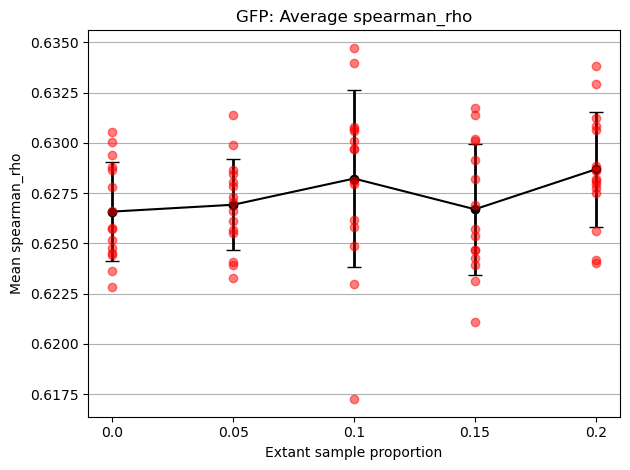

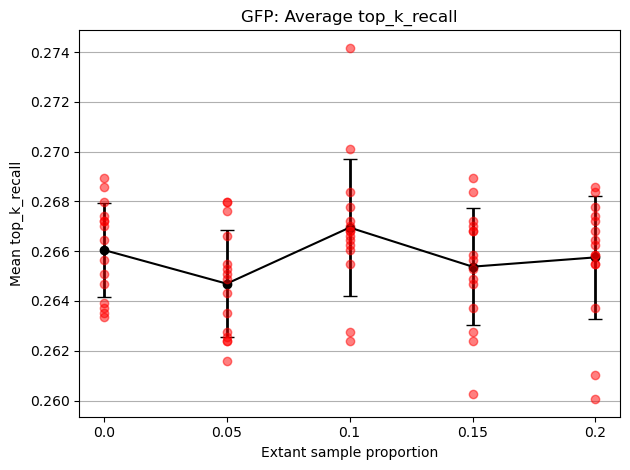

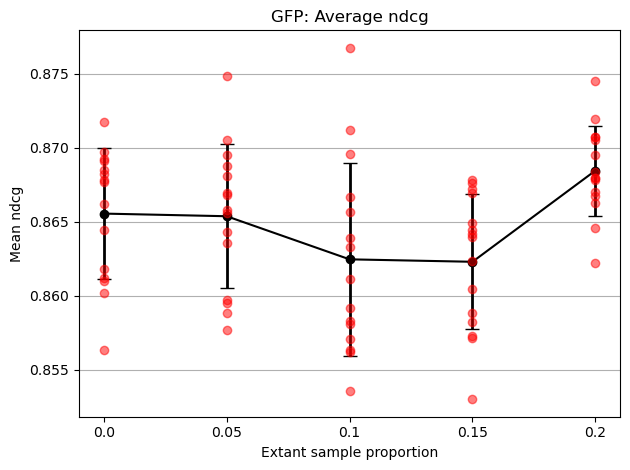

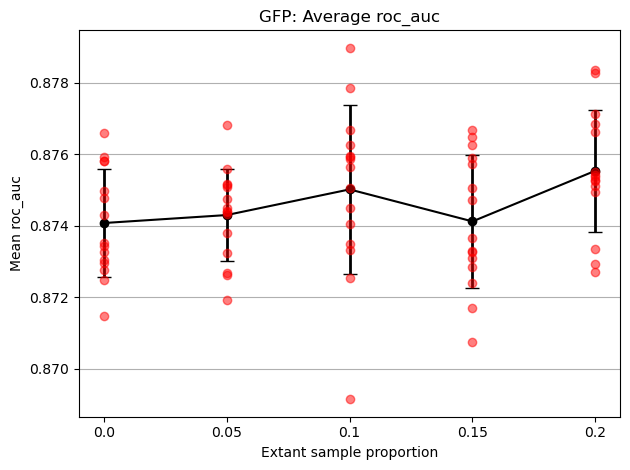

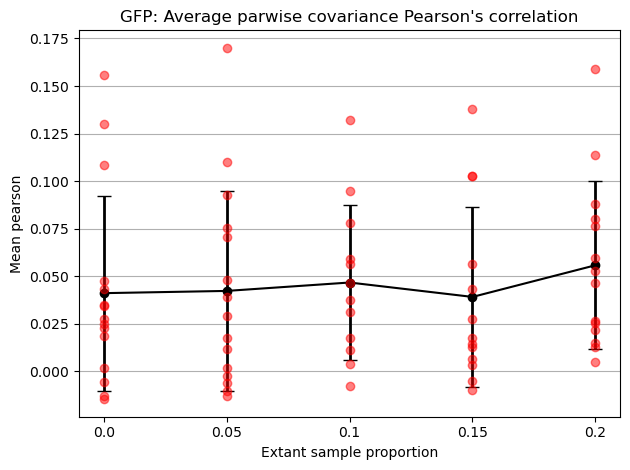

In [21]:
plot_clustering_metrics(gfp_all_cluster_results, "GFP")

# MAFG 

In [ ]:
# read the mmSeqs clustering output 
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/mmseqs_clustering/mafg_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
# subsets of the dataframes based on the cluster it belongs too 
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape

In [ ]:
results.loc[results["is_ancestor"] == 0]

In [ ]:
# actual sampling and then write this to one csv per protein family 

SAMPLE_SIZE = 3000
extant_proportions = [0.15, 0.10, 0.05, 0.0]


aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        test[f"rep_{r}"] = indices

    test.to_csv(f"mafg_{p}_replicates.csv", index=False)

### MAFG - standard results - loss

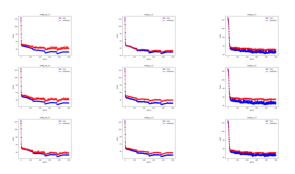

In [9]:
mafg_std_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/raw_data/mafg_standard/"
#mafg_std_file_path = "/Users/sebs_mac/reweighting/mafg/standard/"
plot_standard_loss(mafg_std_file_path, "mafg_std_loss.png", columns=3, rows=3)

#### MAFG Standard results

['ae' 'a' 'e' 'random']


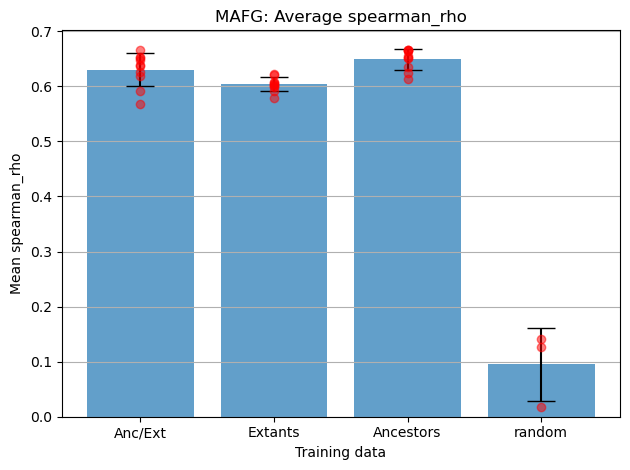

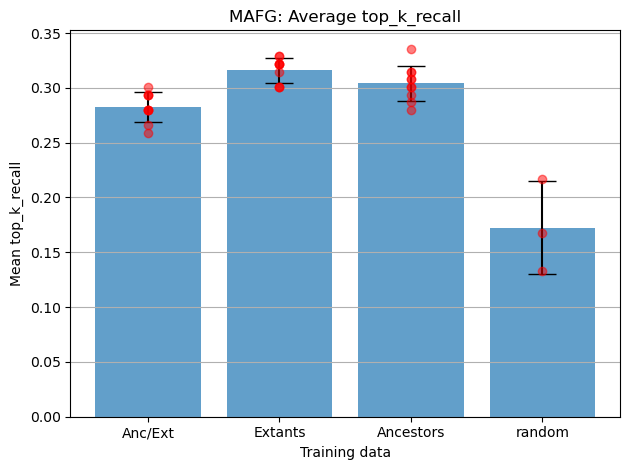

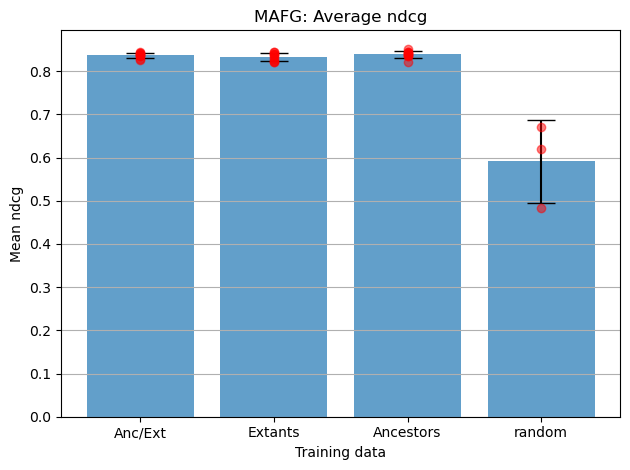

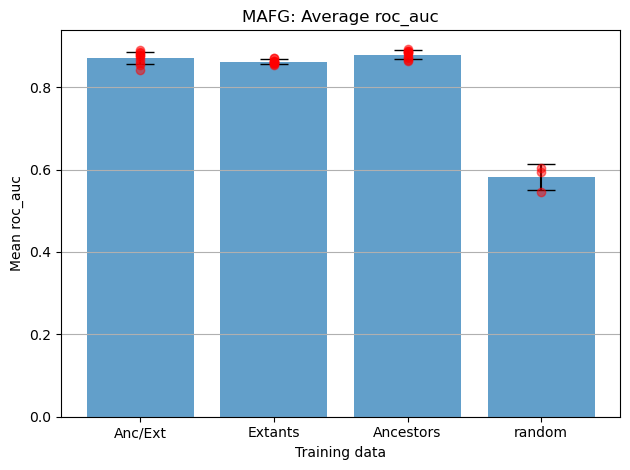

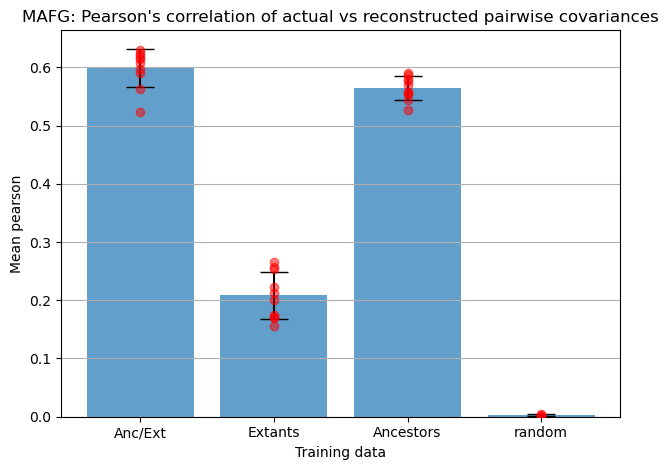

In [19]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/"
mafg = pd.read_csv(path + "mafg_standard_results.csv")

print(mafg["sample"].unique())
protein_name = "MAFG"

labels = ["ae", "e", "a", "random"]
readable_labels = ["Anc/Ext", "Extants", "Ancestors", "random"]

plot_metrics(mafg, labels, readable_labels, protein_name)

In [16]:
mafg_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/mafg_clusters/"

#plot_clustering_loss(mafg_file_path, "mafg_cluster_loss.png", columns=4, rows=3)

In [17]:
mafg_all_clstr_results =combine_clustering_replicates(mafg_file_path, max_reps=15)
mafg_all_clstr_results.head()

(60, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./mafg_0.05_r1/,0.640814,0.300699,0.822697,0.881570,0.406622
1,./mafg_0.1_r1/,0.564564,0.293706,0.840101,0.836956,0.260396
2,./mafg_0.0_r1/,0.637361,0.251748,0.823516,0.882556,0.478386
3,./mafg_0.15_r1/,0.643545,0.307692,0.836782,0.877350,0.305849
4,./mafg_0.05_r2/,0.602816,0.293706,0.841550,0.857677,0.251847


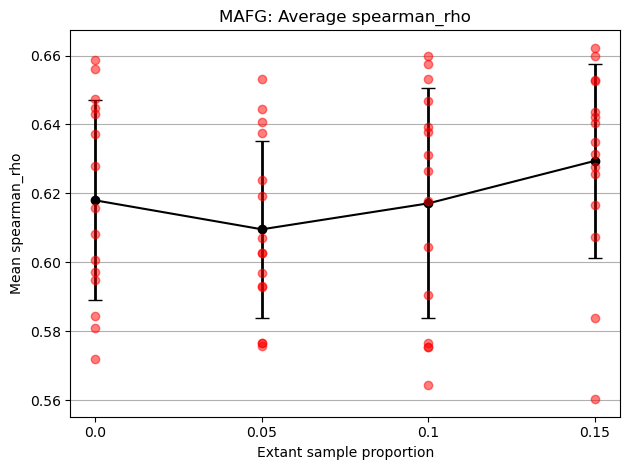

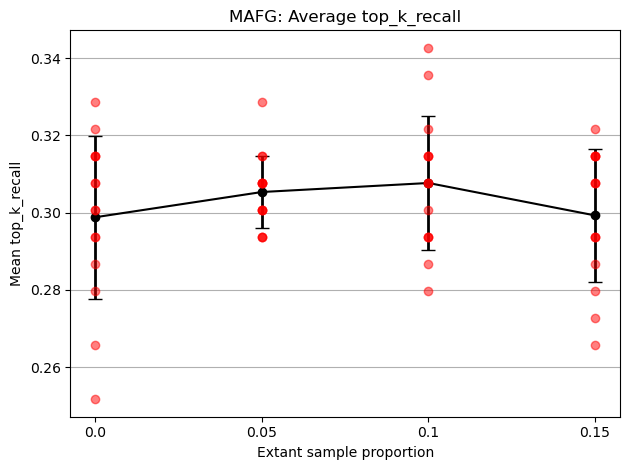

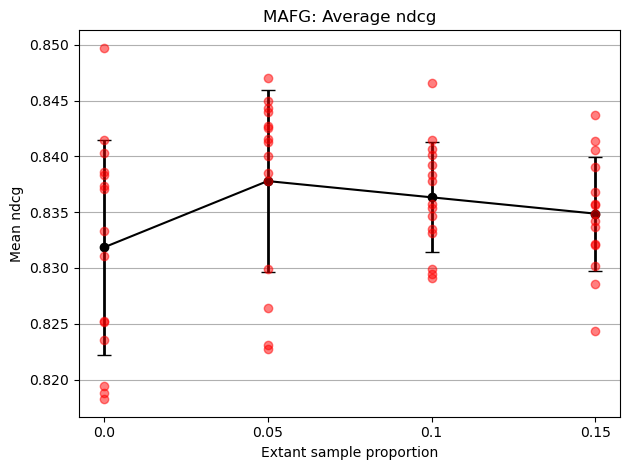

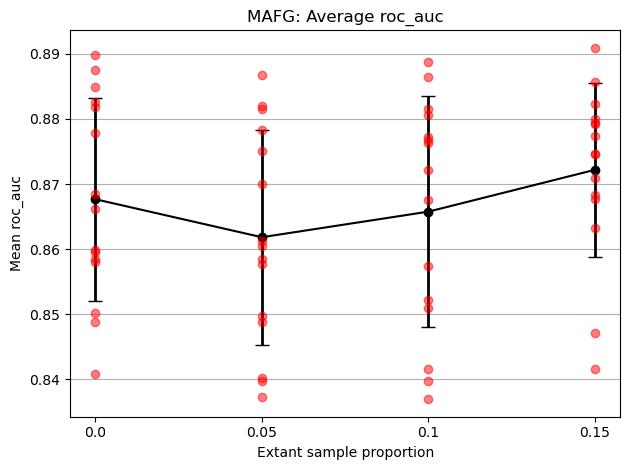

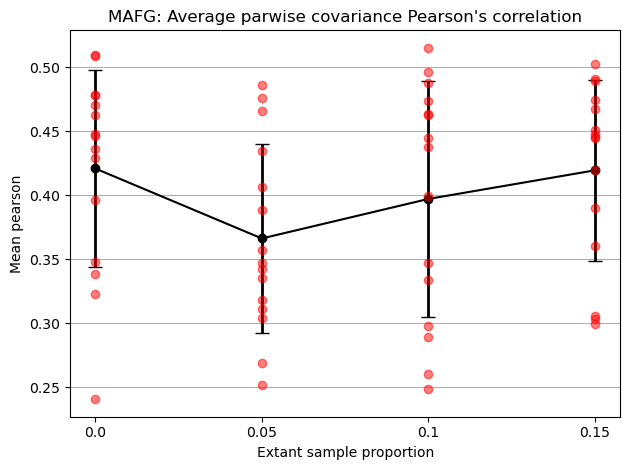

In [18]:
plot_clustering_metrics(mafg_all_clstr_results, "MAFG")

# PTE - Jackson Paper

### clustering data generation

In [ ]:
# read the mmSeqs clustering output 
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/pte_jackson/mmseqs_clustering/pte_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "Node" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
# subsets of the dataframes based on the cluster it belongs too 
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape

In [ ]:
results

In [ ]:

SAMPLE_SIZE = 3000
extant_proportions = [0, 60, 120, 180]

aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/pte_jackson/alns/encoded_weighted/PTE_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()
    for r in range(1, 16):
        indices = []
        
        indices.extend(list(aln.loc[~aln["id"].str.contains("Node")].sample(n=p).index))
        indices.extend(list(results.loc[aln["id"].str.contains("Node")].sample(n=SAMPLE_SIZE - p).index))

        test[f"rep_{r}"] = indices


    test.to_csv(f"pte_{round(p/SAMPLE_SIZE, 2)}_replicates.csv", index=False)

In [ ]:
test = pd.read_csv("pte_0.0_replicates.csv")["rep_11"]
thing = aln.loc[test]

In [ ]:
thing[thing["id"].str.contains("Node")]

### standard results

In [ ]:
pte_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/pte_standard/"

figure_name = "pte_standard_loss.png"

plot_standard_loss(pte_file_path, figure_name, columns=3, rows=3)

In [ ]:
pte_std_results = combine_standard_replicates(pte_file_path, max_reps=10)

In [ ]:
plot_standard_metrics(pte_std_results, "PTE")

# K-fold validation 

### GB1

In [ ]:
path = "/Users/sebs_mac/k_fold_results/gb1/"